In [1]:
#Keras Model Visualization

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import os
import numpy as np
import matplotlib.pyplot as plt
batchsize = 10
NUM_EPOCHS = 10
#img_width, img_height = 150, 150
#for VGG 16 use 224 image size
img_width, img_height = 224, 224

Using TensorFlow backend.


In [2]:
train_dir = 'furniture_images/train'
val_dir = 'furniture_images/val'

train_bed_dir = os.path.join(train_dir, 'bed') 
train_chair_dir = os.path.join(train_dir, 'chair')  
train_sofa_dir = os.path.join(train_dir, 'sofa') 
val_bed_dir = os.path.join(val_dir, 'bed')  
val_chair_dir = os.path.join(val_dir, 'chair')  
val_sofa_dir = os.path.join(val_dir, 'sofa')  


In [3]:
num_bed_train = len(os.listdir(train_bed_dir))
num_chair_train = len(os.listdir(train_chair_dir))
num_sofa_train = len(os.listdir(train_sofa_dir))

num_bed_val = len(os.listdir(val_bed_dir))
num_chair_val = len(os.listdir(val_chair_dir))
num_sofa_val = len(os.listdir(val_sofa_dir))

num_train_images = num_bed_train + num_chair_train + num_sofa_train
num_val_images = num_bed_val + num_chair_val + num_sofa_val
print(num_train_images, num_val_images)

1351 156


In [4]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 1352 images belonging to 3 classes.


In [5]:
val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 156 images belonging to 3 classes.


In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
#BUILD A CUSTOM MODEL - SKIP THIS STEP IF YOU USE VGG16.  FOR CUSTOM MODEL USE THIS STEP AND SKIP NEXT TWO STEPS
model = Sequential([
    Conv2D(96, 11, padding='valid', activation='relu', 
           input_shape=(img_height, img_width ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(256, 5, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(384, 3, padding='same', activation='relu'),
    Conv2D(384, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(1024, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(3)
])


In [7]:
#BUILD VGG - SKIP CUSTOM MODEL STEP IF YOU USE VGG
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

In [8]:
#BUILD VGG - SKIP CUSTOM MODEL STEP IF YOU USE VGG
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model




class_list = ["bed", "chair", "sofa"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [9]:
#APPLICABLE FOR CUSTOM MODEL
#model.compile(optimizer='adam',
 #             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 #             metrics=['accuracy'])

#APPLICABLE FOR VGG & INCEPTION
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
history = model.fit(train_generator,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,validation_data=val_generator, validation_steps=num_val_images // batchsize)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 135 steps, validate for 15 steps
Epoch 1/10
135/135 [==============================] - 146s 1s/step - loss: 1.8203 - accuracy: 0.4493 - val_loss: 0.6495 - val_accuracy: 0.7000
Epoch 2/10
135/135 [==============================] - 151s 1s/step - loss: 1.2111 - accuracy: 0.6140 - val_loss: 0.5174 - val_accuracy: 0.8067
Epoch 3/10
135/135 [==============================] - 151s 1s/step - loss: 0.9528 - accuracy: 0.6893 - val_loss: 0.4765 - val_accuracy: 0.8267
Epoch 4/10
135/135 [==============================] - 152s 1s/step - loss: 0.8207 - accuracy: 0.7139 - val_loss: 0.4881 - val_accuracy: 0.8133
Epoch 5/10
135/135 [==============================] - 152s 1s/step - loss: 0.8057 - accuracy: 0.7355 - val_loss: 0.4780 - val_accuracy: 0.8267
Epoch 6/10
135/135 [==============================] - 152s 1s/step - loss: 0.7528 - accuracy: 0.7571 - val_loss: 0.3842 - val_accuracy: 0.8333
Epoch 7/10
135/135 [=============================

In [12]:
print(len(model.layers))

26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


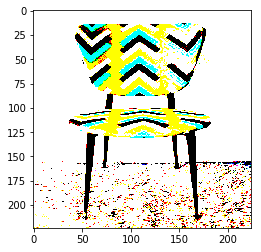

In [13]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = 'furniture_images/test/chair/00000800testchair.jpg'
#img_path = 'furniture_images/test/bed/00000876trainbed.jpg'
#img_path = 'furniture_images/test/sofa/00000803testsofa.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

featuremap = model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print (img_tensor.shape)

In [14]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_modelfig = Model(inputs=model.input, outputs=layer_outputs)
activationsfig = activation_modelfig.predict(img_tensor)

(1, 224, 224, 3)


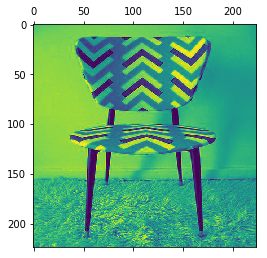

In [15]:
first_layer_activation = activationsfig[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

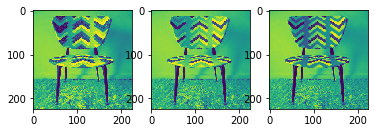

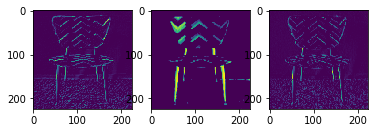

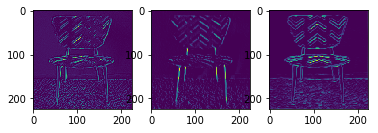

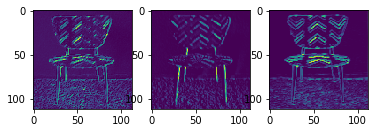

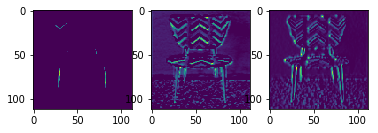

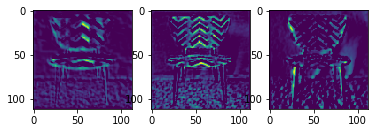

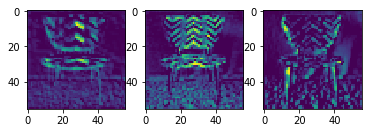

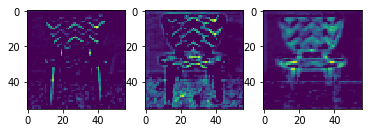

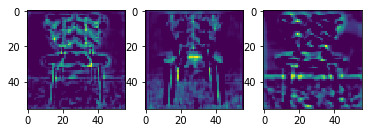

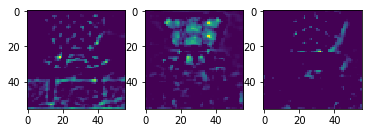

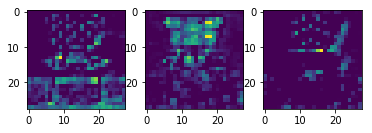

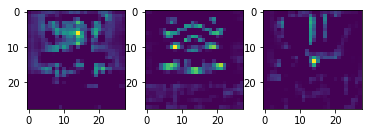

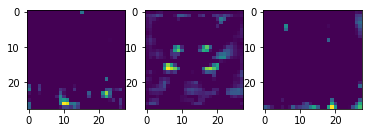

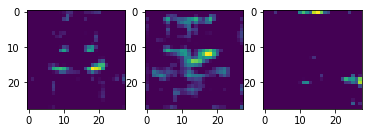

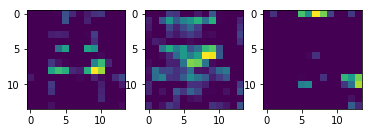

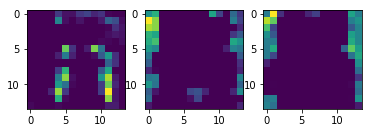

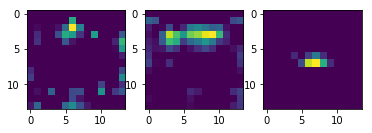

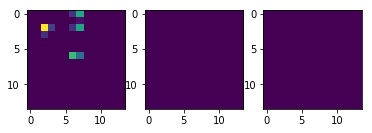

In [21]:
for i in range(0,len(model.layers)-8):
    current_layer_activation = activationsfig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(133)
    plt.subplot(133)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')
    